# Individual Final Report: Beer Dataset

## Goal: 

* Discover variables (drivers) contributing to the quality of beer ratings
* Utilize these drivers to predict categories of beer rating based on qualities and sub ratings
* Utilize this final categorization model in predicting perception of quality of beers going forward

## Imports

In [26]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from wrangle import get_beer, split_data, review_categorizer, wrangle_beer, find_lager, find_barley

## Acquire

* Acquired data from data.world BeerAdvocate dataset
* Dataset originally had 1.5 million rows and 13 columns

In [2]:
df = get_beer()

## Prepare

* Eliminated columns that are not immediately useful to the project
* Created new, pre-encoded categorical column showing if a beer is a lager or ale and if beer uses barley or not
* Filled nulls in ABV column with mode of beer ABV (5%) as this matches overall average beer ABV
* Created categorical version of target variable for categorization model
* Same rows, but final dataframe had 12 columns
* Split data into train, validate, and test groups in a 60/20/20 split 
* All alpha values set at .05

In [3]:
df = wrangle_beer()

In [4]:
#train, validate, and test split
train, validate, test = split_data(df, col_to_stratify='review_cat')


In [5]:
# splits into x and y for features and target variable on train, test, and validate
X_train = train.drop(columns=['review_overall', 'review_appearance', 'beer_style', 'review_palate', 'review_taste', 'beer_name', 'beer_beerid', 'review_cat'])
y_train = train.review_cat

X_validate = validate.drop(columns=['review_overall', 'review_appearance', 'beer_style', 'review_palate', 'review_taste', 'beer_name', 'beer_beerid', 'review_cat'])
y_validate = validate.review_cat

X_test = test.drop(columns=['review_overall', 'review_appearance', 'beer_style', 'review_palate', 'review_taste', 'beer_name', 'beer_beerid', 'review_cat'])
y_test = test.review_cat

## Data Dictionary

The following dictionary only defines columns used in analysis for this dataset. Each row represents an individual beer review.

| Feature | Definition |
|:--------|:-----------|
|Overall Quality Review| Rating from 1 to 5 of overall beer quality from an individual user on BeerAdvocate.com, target variable|
|Review Category| Transformation of target variable into 5 categories: 0-1 = 1, 1-2 = 2, etc.|
|Aroma Review| Rating from 1 to 5 of quality for beer smell|
|Appearance Review| Rating from 1 to 5 of beer's appearance |
|Palate Review| Rating from 1 to 5 of how beer feels in one's mouth|
|Taste Review| Rating from 1 to 5 of how beer tastes|
|Beer Style| string stating the name of the style of beer, 104 unique values|
|Beer Name| String stating name of beer|
|Beer ABV| Float displaying percentage of alcohol in beer|
|Beer ID| Numeric identifier of individual beer|
|Is Lager| Encoded column stating if a beer is a lager or not, derived from Beer Style column|
|Is Barley| Encoded column stating if a beer primarily uses barley as a malt (grain) ingeredient or not, derived from Beer Style column|

## Explore

### Overall review and summary of data

In [6]:
train.describe()

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,is_lager,is_barley,review_cat
count,951968.000000,951968.000000,951968.000000,951968.000000,951968.000000,951968.000000,951968.000000,951968.000000,951968.000000,951968.000000
mean,3.815627,3.736057,3.841506,3.743416,3.793138,6.953427,21715.507504,0.233275,0.860780,4.035455
std,0.720539,0.697346,0.616153,0.682205,0.731730,2.307333,21821.529150,0.422916,0.346176,0.770258
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.010000,3.000000,0.000000,0.000000,1.000000
25%,3.500000,3.500000,3.500000,3.500000,3.500000,5.100000,1717.000000,0.000000,1.000000,4.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,6.300000,13906.000000,0.000000,1.000000,4.000000
75%,4.500000,4.000000,4.000000,4.000000,4.500000,8.400000,39441.000000,0.000000,1.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,57.700000,77317.000000,1.000000,1.000000,5.000000


In [7]:
train.head().T

,571456,662029,668428,413225,912613
review_overall,4.5,4.0,4.0,4.0,3.0
review_aroma,4.0,4.0,4.0,4.0,3.0
review_appearance,3.5,2.5,3.5,3.5,3.5
beer_style,Saison / Farmhouse Ale,American IPA,Kölsch,American Strong Ale,English Brown Ale
review_palate,4.0,3.0,3.5,4.0,3.5
review_taste,4.0,3.0,4.0,4.0,3.5
beer_name,Bam Noire,Duet IPA,Reissdorf Kölsch,Great Lakes Nosferatu,Brown Ale
beer_abv,4.3,7.0,4.8,8.0,5.4
beer_beerid,38459,27604,2040,1792,16879
is_lager,0,0,0,1,0


### Overall view of target variable

<function matplotlib.pyplot.show(close=None, block=None)>

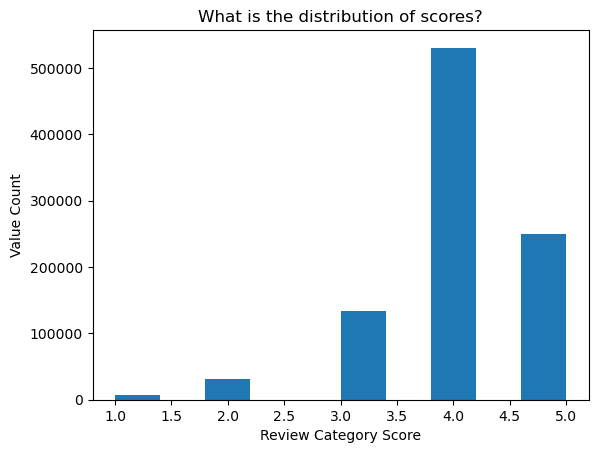

In [8]:
train.review_cat.hist(grid=False)
plt.ylabel('Value Count')
plt.xlabel('Review Category Score')
plt.title('What is the distribution of scores?')
plt.show

* Most reviews fall in the 4 category, we cannot treat the distribution as normal

### Which subratings of beer quality are most highly correlated with overall quality?

In [9]:
train.corr()['review_cat']

/var/folders/_6/0nkpzhxj2_n85fz5s1rk__xr0000gn/T/ipykernel_26194/2689449298.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()['review_cat']


review_overall       0.946740
review_aroma         0.583325
review_appearance    0.474821
review_palate        0.662622
review_taste         0.745791
beer_abv             0.136423
beer_beerid          0.003839
is_lager            -0.140453
is_barley            0.084680
review_cat           1.000000
Name: review_cat, dtype: float64

* Subjective subratings are most highly correlated, but this makes sense. Are the objective categories statistically significantly correlated?

In [10]:
# statistical significant relationship between overall review and lager vs ale? Yes

corr, p = stats.pearsonr(train.review_overall, train.is_lager)
corr, p


(-0.14747029204987488, 0.0)

In [11]:
# statistical significant relationship between overall review and barley vs non-barley beers? Yes
corr, p = stats.pearsonr(train.review_overall, train.is_barley)
corr, p


(0.08955457575396884, 0.0)

In [12]:
# statistical significant relationship between overall review and abv? Yes

corr, p = stats.pearsonr(train.review_overall, train.beer_abv)
corr, p

(0.14287864024093855, 0.0)

### Is there a difference between quality rating of lagers vs ales?

<function matplotlib.pyplot.show(close=None, block=None)>

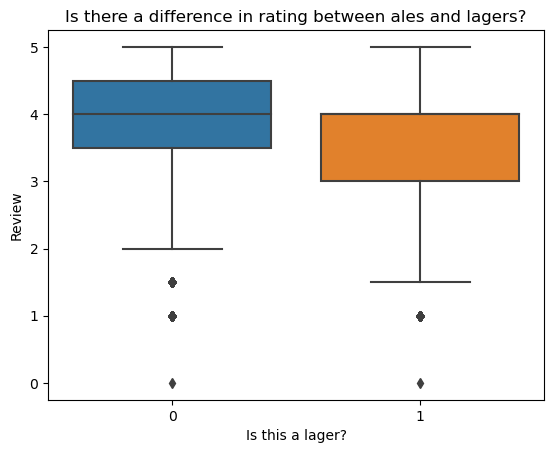

In [16]:
sns.boxplot(data=train, x='is_lager', y='review_overall')
plt.ylabel('Review')
plt.xlabel('Is this a lager?')
plt.title('Is there a difference in rating between ales and lagers?')
plt.show

Is there a statistically significant difference in mean overall score between ales and lagers?

Ho: No statistically significant difference between the mean scores of ales and lagers
Ha: There is a statistically significant difference between the mean scores of ales and lagers

In [15]:
# independent, one sided mann whitney test measuring statistical significance absent of normal distribution

stats.mannwhitneyu(train[train.is_lager==0].review_overall, 
             train[train.is_lager==1].review_overall, alternative='greater')


MannwhitneyuResult(statistic=95083323202.0, pvalue=0.0)

#### We reject the null hypothesis. Ales are reated higher on average than lagers

### Is there a difference between quality rating of barley vs non-barley malt beers?

<function matplotlib.pyplot.show(close=None, block=None)>

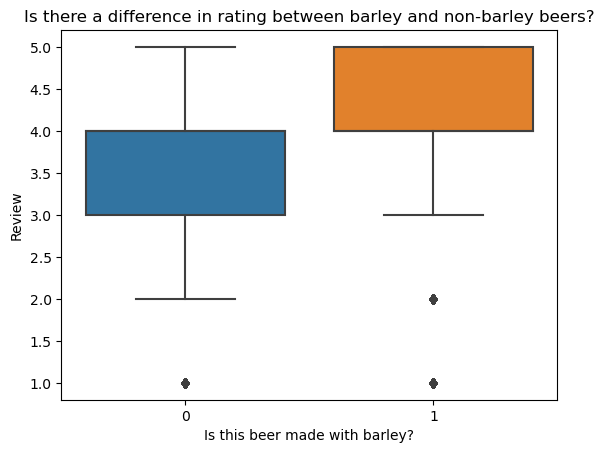

In [20]:
sns.boxplot(data=train, x='is_barley', y='review_cat')
plt.ylabel('Review')
plt.xlabel('Is this beer made with barley?')
plt.title('Is there a difference in rating between barley and non-barley beers?')
plt.show

Is there statistically significant difference in mean overall score between barley and not barley beers?

Ho: No statistically significant difference between the mean scores of barley and not barley beers
Ha: There is a statistically significant difference between the mean scores of barley and not barley beers

In [21]:
# independent, one sided mann whitney test measuring statistical significance absent of normal distribution

stats.mannwhitneyu(train[train.is_barley==0].review_overall, 
             train[train.is_barley==1].review_overall, alternative='less')


MannwhitneyuResult(statistic=47525374106.5, pvalue=0.0)

#### We reject the null hypothesis. Traditional barley beers are rated higher on average. 

### How does ABV contribute to perception of beer quality?

<function matplotlib.pyplot.show(close=None, block=None)>

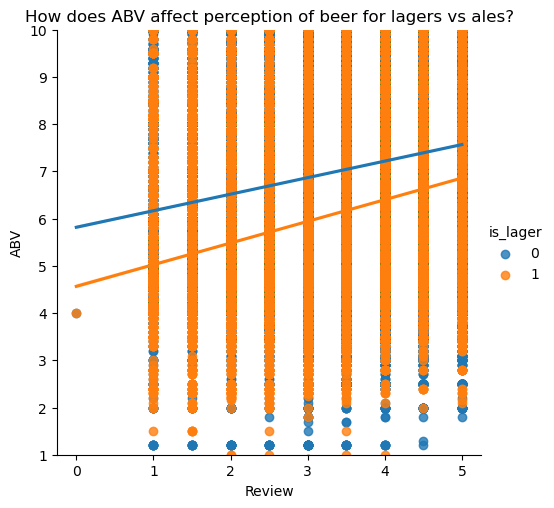

In [23]:
sns.lmplot(x='review_overall', y='beer_abv', data=train, scatter=True, hue='is_lager')
plt.ylim(1,10)
plt.ylabel('ABV')
plt.xlabel('Review')
plt.title('How does ABV affect perception of beer for lagers vs ales?')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

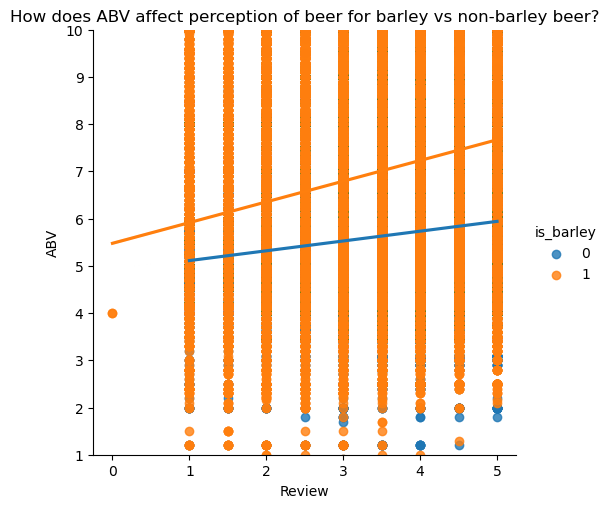

In [24]:
sns.lmplot(x='review_overall', y='beer_abv', data=train, scatter=True, hue='is_barley')
plt.ylim(1,10)
plt.ylabel('ABV')
plt.xlabel('Review')
plt.title('How does ABV affect perception of beer for barley vs non-barley beer?')
plt.show

### Exploration Summary

* Most subjective review subcategories are too interrelated with the overall score to use in modeling. The exception is aroma, something that can be altered separately in the brewing process.
* Ales are statistically significantly rated of higher quality than lagers
* Traditional beers using barley as a grain are statistically significantly rated higher than other malts.
* Higher ABV (around 6-7%) tends to mean a higher rating

## Modeling

* We will use accuracy as a primary metric to compare to baseline and also examine of other metrics hold up between variations of hyperparameters
* Baseline accuracy is 56%. The model will have to exceed this to be effective. 
* We will utilize Random Forest modeling as this introduces randomness and parameters can be easily modified
* We will iterate through hyperparameters to find accuracy, compare this using validate data, and 

In [25]:
# Use mode as baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 4

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.56


In [31]:
for i in range(2, 11):
    # Makes Random Forest Model
    forest = RandomForestClassifier(max_depth=i, random_state=7)

    # Fit the model 
    forest = forest.fit(X_train, y_train)

    # Use model
    # Evaluate on train
    y_predictions = forest.predict(X_train)

    # Produce report on actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                1        2              3              4         5  accuracy  \
precision     0.0      0.0       0.431334       0.568854       0.0  0.564603   
recall        0.0      0.0       0.094364       0.988778       0.0  0.564603   
f1-score      0.0      0.0       0.154851       0.722212       0.0  0.564603   
support    6577.0  30720.0  134500.000000  530748.000000  249423.0  0.564603   

               macro avg   weighted avg  
precision       0.200038       0.378093  
recall          0.216628       0.564603  
f1-score        0.175413       0.424531  
support    951968.000000  951968.000000  

Tree with max depth of 3
                1        2              3              4              5  \
precision     0.0      0.0       0.444579       0.613395       0.558611   
recall        0.0      0.0       0.187814       0.858681       0.340787   
f1-score      0.0      0.0       0.264071       0.715602       0.423322   
support    6577.0  30720.0  134500.000

#### Models of depth 9 seem to strike a balance between high accuracy and other scores as well as not being too overfit

In [28]:
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=7)

    # Fit the model on train
    forest = forest.fit(X_train, y_train)

    # Use the model
    # evaluate on train and then validate
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.564603,0.564557,0.000046
1,3,0.594562,0.594155,0.000407
2,4,0.603571,0.603218,0.000353
3,5,0.606045,0.606039,0.000006
4,6,0.607572,0.607469,0.000103
5,7,0.609074,0.608582,0.000492
6,8,0.609670,0.608853,0.000817
7,9,0.610617,0.609480,0.001137
8,10,0.611282,0.609754,0.001528
9,11,0.612060,0.609537,0.002524


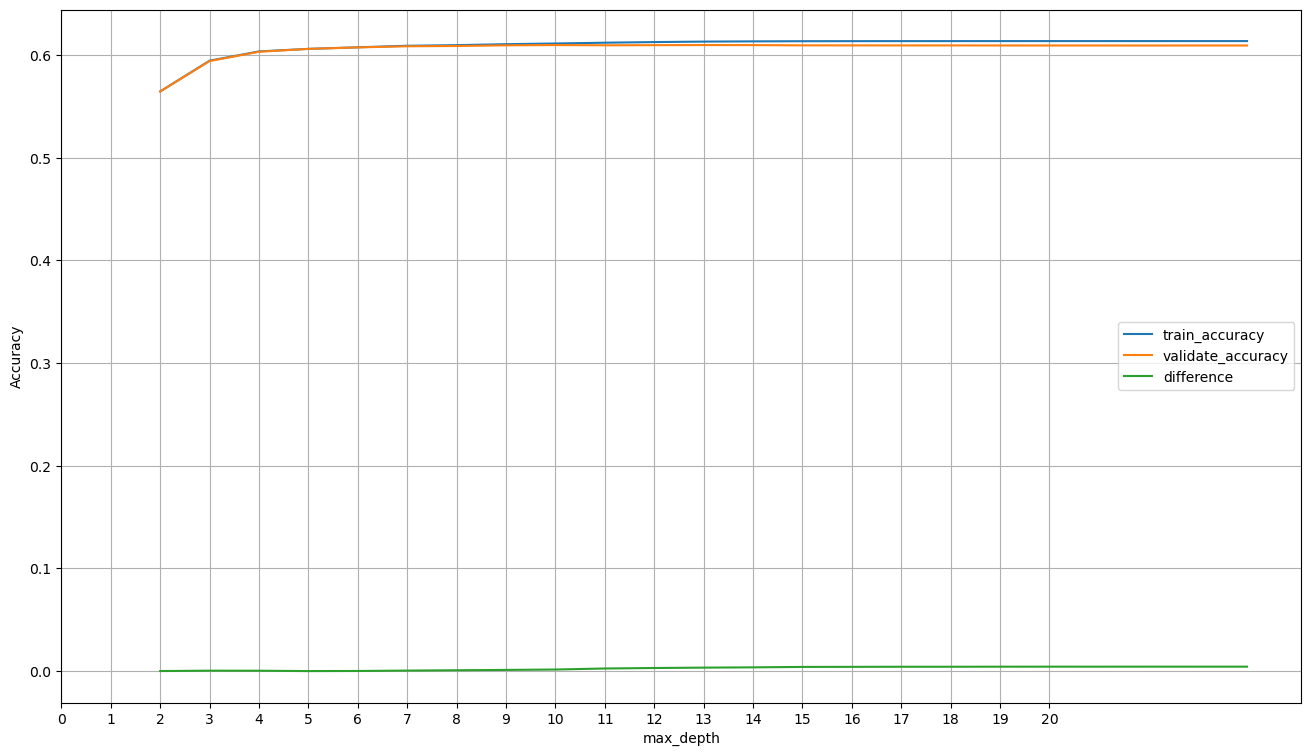

In [29]:
df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [30]:
# make final model
forest = RandomForestClassifier(max_depth=9, random_state=7)

# fit final model
forest = forest.fit(X_train, y_train)

#calculate train accuracy of final model
in_sample_accuracy = forest.score(X_train, y_train)

#calculate on test
out_of_sample_accuracy = forest.score(X_validate, y_validate)

In [32]:
in_sample_accuracy

0.6106171636021379

In [33]:
out_of_sample_accuracy

0.6094799305439568

Our depth 9 model beats baseline by 4-5% and train accuracy compares closely with test accuracy

## Conclusions

### Exploration

* Ales are Rated Higher than Lagers on average, this could be due to perceptions of low quality in American Adjunct lagers
* Traditional barley malt is rated higher than unconventional malts like rye or wheat
* Subcategories of review are not terribly useful in prediction as they are too closely related to overall ratings
* However, scent of beer could be a useful predictor due to its relatively low correlation with overall rating and potentially separate process in brewing

### Modeling

* The final model outperforms baseline by 4-5% and does not seem overfit
* Additional objective variables could be useful to increase predictive capability
* This model seems best at predicting the 4 category of rating, this being the most common rating

### Recommendations

* For a broadly appealing beer, focus first on long fermentation, this will smooth out the beer and increase ABV
* Ales are a good bet for an overall more appealing beer
* Stick to traditional malts to increase sales